# Human Pose Estimation

TODO: Purpose, Motivation
example image

## Choosing a model

Constraints:
- multi-person: The model should be able to detect several people at once in a frame.
- real-time: The model should be able to infer the pose predictions in real time from a live video feed such as from a laptop webcam. GPU availability should not be assumed.

We found the YOLOv7 architecture to be quite accurate, however not suitable for real-time estimation on our mobile machines due to considerable lag when working with the webcam feed.

Another quite accurate and fast model is Mediapipe, although it only supports single-person pose estimation.

We decided on the __MoveNet__ architecture by TensorFlow as it specifically provides versions of the model on TF Hub for latency-critical applications.

In [1]:
# Import dependencies.
%matplotlib inline
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import matplotlib.pyplot as plt
import time
import tqdm

In [2]:
# Check for GPU usage
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[]

In [3]:
# Download the model from TF Hub.
# The Lightning version is specifically designed for 
model = hub.load("https://www.kaggle.com/models/google/movenet/frameworks/TensorFlow2/variations/multipose-lightning/versions/1")
movenet = model.signatures['serving_default']

In [4]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    0: 'nose',
    1: 'left_eye',
    2: 'right_eye',
    3: 'left_ear',
    4: 'right_ear',
    5: 'left_shoulder',
    6: 'right_shoulder',
    7: 'left_elbow',
    8: 'right_elbow',
    9: 'left_wrist',
    10: 'right_wrist',
    11: 'left_hip',
    12: 'right_hip',
    13: 'left_knee',
    14: 'right_knee',
    15: 'left_ankle',
    16: 'right_ankle'
}

# Maps bones to an RGB color
EDGES_DICT = {
    (0, 1): (255,0,0),
    (0, 2): (0,0,255),
    (1, 3): (255,0,0),
    (2, 4): (0,0,255),
    (0, 5): (255,0,0),
    (0, 6): (0,0,255),
    (5, 7): (255,0,0),
    (7, 9): (255,0,0),
    (6, 8): (0,0,255),
    (8, 10): (0,0,255),
    (5, 6): (0,255,0),
    (5, 11): (255,0,0),
    (6, 12): (0,0,255),
    (11, 12): (0,255,0),
    (11, 13): (255,0,0),
    (13, 15): (255,0,0),
    (12, 14): (0,0,255),
    (14, 16): (0,0,255)
}

## Inputs

A frame of video or an image, represented as an int32 (for TF.js) or uint8 (for TF Lite) tensor of
dynamic shape: 1xHxWx3, where H and W need to be a multiple of 32 and can be determined
at run time. A recommended way to prepare the input image tensor is to resize the image such
that its larger side is equal to 256 pixels while keeping the image’s original aspect ratio. Note
that the size of the input image controls the tradeoff between speed vs. accuracy so choose the
value that best suits your application. The channel order is RGB with values in [0, 255].

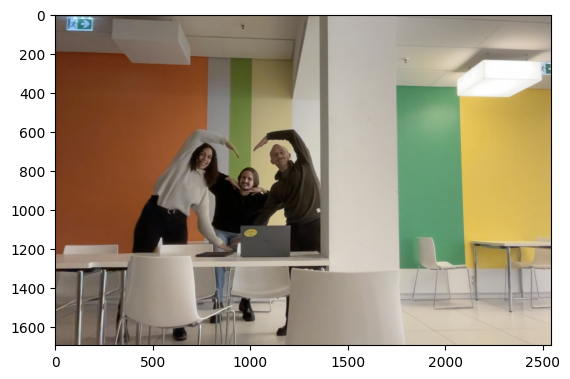

In [5]:
example_image = cv2.imread("Foto am 17.01.24 um 09.56.jpg")
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)
plt.imshow(example_image)

In [6]:
example_image.shape

(1694, 2542, 3)

According to the input requirements, the the image should have four dimensions. Since MoveNet requires a tensor as input which we won't be able to visualize later, we will run the preprocessing and inference on a copy of the image numpy array instead.

In [7]:
image_copy = example_image.copy()
image_copy = tf.expand_dims(image_copy, axis=0)
image_copy.shape

TensorShape([1, 1694, 2542, 3])

In [8]:
# image pixel dimensions have to be multiples of 32 and of type int32
image_copy = tf.image.resize_with_pad(image_copy,320,512)
image_copy = tf.cast(image_copy, dtype=tf.int32)
image_copy

<tf.Tensor: shape=(1, 320, 512, 3), dtype=int32, numpy=
array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]]], dtype=int32)>

In [9]:
# Run the model and print inference time
start = time.process_time()
example_results = movenet(image_copy)
print(time.process_time() - start)

0.47447000000000017


## Outputs

A float32 tensor of shape [1, 6, 56].
- The first dimension is the batch dimension, which is always equal to 1.
- The second dimension corresponds to the maximum number of instance detections. The
model can detect up to 6 people in the image frame simultaneously.
- The third dimension represents the predicted bounding box/keypoint locations and
scores. The first 17 * 3 elements are the keypoint locations and scores in the format:
[y_0, x_0, s_0, y_1, x_1, s_1, …, y_16, x_16, s_16], where y_i, x_i, s_i are the
yx-coordinates (normalized to image frame, e.g. range in [0.0, 1.0]) and confidence
scores of the i-th joint correspondingly. The order of the 17 keypoint joints is: [nose, left
eye, right eye, left ear, right ear, left shoulder, right shoulder, left elbow, right elbow, left
wrist, right wrist, left hip, right hip, left knee, right knee, left ankle, right ankle]. The
remaining 5 elements [ymin, xmin, ymax, xmax, score] represent the region of the
bounding box (in normalized coordinates) and the confidence score of the instance.

For the extraction of the keypoints, we need to do some indexing gymnastics.

In [10]:
print(example_results)

{'output_0': <tf.Tensor: shape=(1, 6, 56), dtype=float32, numpy=
array([[[4.39880610e-01, 3.13545316e-01, 5.27470231e-01, 4.34392512e-01,
         3.20103109e-01, 5.74630380e-01, 4.26767439e-01, 3.10531139e-01,
         6.49304152e-01, 4.42952871e-01, 3.22316349e-01, 6.31932259e-01,
         4.26207542e-01, 2.99156070e-01, 6.84024811e-01, 5.21503150e-01,
         3.10174108e-01, 4.75884110e-01, 4.44187641e-01, 2.72297084e-01,
         6.76532328e-01, 6.33556485e-01, 3.11752647e-01, 6.25278115e-01,
         4.48561251e-01, 2.66799957e-01, 8.93437341e-02, 6.92647696e-01,
         3.45766038e-01, 3.60607028e-01, 4.55674738e-01, 3.11680049e-01,
         5.02650104e-02, 6.27463877e-01, 2.59129375e-01, 8.38278890e-01,
         5.96911490e-01, 2.16462702e-01, 8.63112986e-01, 7.64874578e-01,
         2.58796394e-01, 4.30405736e-01, 7.27546334e-01, 1.92947894e-01,
         4.08588946e-01, 8.84202778e-01, 2.56423503e-01, 2.96224177e-01,
         8.72025490e-01, 1.82502091e-01, 4.04147267e-01, 3.

In [11]:
# Extract all batches, all detected persons, all keypoints up to position 51 (after that comes bounding box information we don't need)
# Each keypoint is represented by 3 elements: relative y position, relative x position, confidence score
# Reshape: (detected persons, keypoints, position and confidence score)
keypoints_with_scores = example_results['output_0'].numpy()[:,:,:51].reshape(6,17,3)

Unfortunately, MoveNet does not provide us with pre-defined methods to display the keypoints and edges in the image. We will define them ourselves. We will also implement a confidence threshold, which will only draw keypoints and edges if the model predicts them with a confidence score above the set threshold. We will draw keypoints and edges as circles and lines with the help of cv2.

In [12]:
def draw_keypoints(frame, keypoints_with_scores, confidence_threshold):
    img = frame.copy()
    height, width, _ = img.shape

    for person in keypoints_with_scores:
        for kp in person:
            if kp[2] > confidence_threshold:
                cv2.circle(img, (int(kp[1]*width),int(kp[0]*height)), radius=10, color=(255,255,255), thickness=-1)
    return img

In [13]:
def draw_edges(frame, keypoints_with_scores, confidence_threshold):
    img = frame.copy()
    height, width, _ = img.shape

    for person in keypoints_with_scores:
        # only draw edges defined in EDGES_DICT
        for edge in EDGES_DICT.keys():
            kp_1 = person[edge[0]]
            kp_2 = person[edge[1]]
            if (kp_1[2] > confidence_threshold) and (kp_2[2] > confidence_threshold):
                cv2.line(img,(int(kp_1[1]*width),int(kp_1[0]*height)),(int(kp_2[1]*width),int(kp_2[0]*height)),color=EDGES_DICT[edge], thickness=5)
    return img

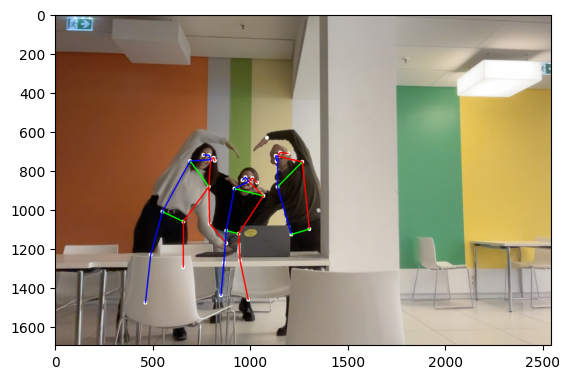

In [14]:
# Draw keypoints and edges
confidence_threshold = 0.3
example_image = draw_edges(draw_keypoints(example_image, keypoints_with_scores,confidence_threshold), keypoints_with_scores, confidence_threshold)
plt.imshow(example_image)

In the example image above, we can observe some of the limitations of the model. Although it can handle occluded body parts well, the clearly visible arms were not detected well. The facial and hip keypoints are also slightly off their true position. Nonetheless, it is a good prediction with about 200ms inference time.

We must also mention the accuracy of the predictions is highly dependent on the resolution of the image. It is common to reduce the resolution to speed up inference, especially for real-time applications.

## Evaluation

Now, we want to quantify the model's performance. For this, we will use a popular human pose estimation data set which is already labeled: the MPII Human Pose Dataset. It includes around 25k images, of which about 11k are annotated. In the following section, we will extract the annotations, run the model and compare the annotations with the inferred keypoints.

To quantify the results, we will use the metric employed by the MPII team: PCKh@0.5.

PCK stands for Percentage of Correct Keypoints. A predicted keypoint is deemed as correct if it is at most half the head size of the person (h@0.5) away from the ground truth.

Limitations:
- only single person
- MoveNet keypoints and annotated keypoints are not congruent: only 12 keypoints match (left shoulder, right shoulder, left elbow, right elbow, left wrist, right wrist, left hip, right hip, left knee, right knee, left ankle, right ankle)

In [15]:
import json

In [16]:
# The MPII annotations are provided in a .mat file, which we have converted to a .json file using MATLAB.
annotations = json.load(open("/Users/chrisgoerner/Documents/Master/AAAI_172492/mpii_human_pose_v1_u12_2/annotations.json"))

In [17]:
# Extract annotated images
annotated = list()
for annotated_image in annotations['RELEASE']['annolist']:
    if 'annopoints' in annotated_image['annorect']:
        annotated.append(annotated_image)


In [18]:
# Print example annotation
annotated[0]

{'image': {'name': '060111501.jpg'},
 'annorect': {'x1': 806.0,
  'y1': 56.0,
  'x2': 901.0,
  'y2': 183.0,
  'annopoints': {'point': [{'x': 904.0,
     'y': 237.0,
     'id': 6.0,
     'is_visible': True},
    {'x': 858.0, 'y': 135.0, 'id': 7.0, 'is_visible': True},
    {'x': 871.1877, 'y': 180.4244, 'id': 8.0, 'is_visible': []},
    {'x': 835.8123, 'y': 58.5756, 'id': 9.0, 'is_visible': []},
    {'x': 980.0, 'y': 322.0, 'id': 0.0, 'is_visible': True},
    {'x': 896.0, 'y': 318.0, 'id': 1.0, 'is_visible': False},
    {'x': 865.0, 'y': 248.0, 'id': 2.0, 'is_visible': True},
    {'x': 943.0, 'y': 226.0, 'id': 3.0, 'is_visible': True},
    {'x': 948.0, 'y': 290.0, 'id': 4.0, 'is_visible': True},
    {'x': 881.0, 'y': 349.0, 'id': 5.0, 'is_visible': True},
    {'x': 772.0, 'y': 294.0, 'id': 10.0, 'is_visible': True},
    {'x': 754.0, 'y': 247.0, 'id': 11.0, 'is_visible': True},
    {'x': 792.0, 'y': 147.0, 'id': 12.0, 'is_visible': True},
    {'x': 923.0, 'y': 123.0, 'id': 13.0, 'is_visib

In [19]:
path = "/Users/chrisgoerner/Documents/Master/AAAI_172492/images/"

In [20]:
# Euclidian distance
def distance(x1, y1, x2, y2):
    return ((x1-x2)**2 + (y1-y2)**2)**(0.5)

In [21]:
# mapping of MoveNet keypoint index to MPII dataset keypoint ID
mapping_movenet_to_mpii = {
    5 : 13,
    6 : 12,
    7 : 14,
    8 : 11,
    9 : 15,
    10 : 10,
    11 : 3,
    12 : 2,
    13 : 4,
    14 : 1,
    15 : 5,
    16: 0
}

In [22]:
evaluation = {
    5 : [],
    6 : [],
    7 : [],
    8 : [],
    9 : [],
    10 : [],
    11 : [],
    12 : [],
    13 : [],
    14 : [],
    15 : [],
    16: []
}

In [23]:
j = 0
for a in annotated:
    # Conduct pose estimation
    image_path = path + a['image']['name']
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    width = im.shape[1]
    height = im.shape[0]
    im_copy = im.copy()
    im_copy = tf.expand_dims(im_copy, axis=0)
    im_copy = tf.image.resize_with_pad(im_copy,320,512)
    im_copy = tf.cast(im_copy, dtype=tf.int32)
    results = movenet(im_copy)
    keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape(6,17,3)

    # Calculate PCKh@0.5
    # Calculate half head size
    half_head_size = 0.5 * distance(a['annorect']['x1'],a['annorect']['y1'],a['annorect']['x2'],a['annorect']['y2'])
    
    for person in keypoints_with_scores:
        # for each keypoint
        for keypoint in mapping_movenet_to_mpii.keys():
            # if the predicted keypoint is actually annotated (sometimes it isn't :/)
            if True in [mapping_movenet_to_mpii[keypoint] == int(x['id']) for x in a['annorect']['annopoints']['point']]:
                movenet_position = person[keypoint]
                mpii_positions = a['annorect']['annopoints']['point']
                x1 = movenet_position[1] * width
                y1 = movenet_position[0] * height
                # consider conversion from movenet keypoint to mpii keypoint
                # get right keypoint from mpii because who actually thought of their weird data structure
                correct_mpii_position = None
                for m in mpii_positions:
                    if int(m['id']) == mapping_movenet_to_mpii[keypoint]:
                        correct_mpii_position = m
                x2 = correct_mpii_position['x']
                y2 = correct_mpii_position['y']
                evaluation[keypoint].append(True if distance(x1,y1,x2,y2) <= half_head_size else False)
        # only for the first detected person, because 
        break

    if j == 100:
        break
    j += 1

In [24]:
evaluation

{5: [True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  False,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  False,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False],
 6: [True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  T

In [25]:
accuracies = {}

In [26]:
# Keypoint-wise calculation of accuracy score
for k in evaluation.keys():
    accuracies[k] = len([i for i in evaluation[k] if i == True]) / len(evaluation[k])

In [27]:
accuracies

{5: 0.8712871287128713,
 6: 0.8712871287128713,
 7: 0.79,
 8: 0.797979797979798,
 9: 0.7474747474747475,
 10: 0.78,
 11: 0.84375,
 12: 0.8229166666666666,
 13: 0.8157894736842105,
 14: 0.75,
 15: 0.6727272727272727,
 16: 0.7090909090909091}

In [28]:
# Replace keypoint index with keypoint name
accuracies = {KEYPOINT_DICT[k] : v for k, v in accuracies.items()}
accuracies

{'left_shoulder': 0.8712871287128713,
 'right_shoulder': 0.8712871287128713,
 'left_elbow': 0.79,
 'right_elbow': 0.797979797979798,
 'left_wrist': 0.7474747474747475,
 'right_wrist': 0.78,
 'left_hip': 0.84375,
 'right_hip': 0.8229166666666666,
 'left_knee': 0.8157894736842105,
 'right_knee': 0.75,
 'left_ankle': 0.6727272727272727,
 'right_ankle': 0.7090909090909091}

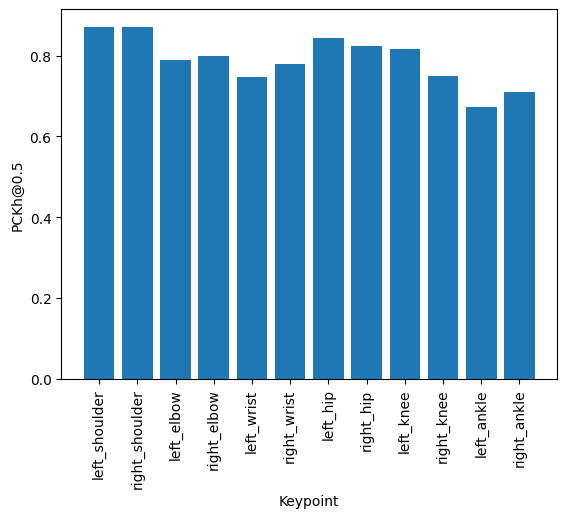

In [29]:
# Plot PCKh@0.5
plt.bar(accuracies.keys(), accuracies.values())
plt.xticks(rotation=90)
plt.xlabel("Keypoint")
plt.ylabel("PCKh@0.5")
plt.show()

## Two-Player Pong Game

Let's actually use some real-time multi-person pose estimation and play pong together! 🏓

Each player controls the paddle on the side with their nose. The leftmost nose belongs to player one, the rightmost nose belongs to player two.

In [16]:
HANDS_ON_HEAD_POSE_JOINTS = ['left_wrist', 'right_wrist', 'nose']

# Funktion zur Überprüfung der "Hands on Head"-Pose für einen Spieler
def is_hands_on_head_pose(keypoints_with_scores, player_index=0, confidence_threshold=0.3):
    pose_confidence = 0.0
    for joint_name in HANDS_ON_HEAD_POSE_JOINTS:
        joint_index = KEYPOINT_DICT[joint_name]
        pose_confidence += keypoints_with_scores[player_index, joint_index, 2]

    average_confidence = pose_confidence / len(HANDS_ON_HEAD_POSE_JOINTS)
    return average_confidence > confidence_threshold


In [17]:
def twoplayer_highest_confidence(keypoints_with_scores):
    # input shape: (6,17,3) (detected people, keypoints, x y and confidence)
    # output shape: (2,17,3) (two people with highest confidence across all keypoints, keypoints, x y and confidence)
    confidence_sums = []
    for person in keypoints_with_scores:
        confidence_sums.append(sum(person[:,2]))
    
    indices_of_highest = sorted(range(len(confidence_sums)), key=lambda i: confidence_sums[i], reverse=True)[:2]
    
    return keypoints_with_scores[indices_of_highest,:,:]

In [18]:
# Pong game parameters

ball_radius = 20
paddle_width, paddle_height = 20, 100
ball_speed = 10
paddle_speed = 3
score_left = 0
score_right = 0

game_over_threshold = 5
game_over = False
game_over_text = ""
replay_text = 'Press r to play again'

def reset_game():
    global score_left, score_right, right_paddle_y, left_paddle_y, ball_x, ball_y, ball_dx, ball_dy, ball_speed, game_over
    score_left = 0
    score_right = 0
    right_paddle_y = height // 2
    left_paddle_y = height // 2
    ball_x, ball_y = width // 2, height // 2
    ball_dx, ball_dy = ball_speed, ball_speed
    game_over = False
    ball_dx, ball_dy =3, 3


## RUN PONG

In [19]:
cap = cv2.VideoCapture(0)

cap.set(3,1000)
cap.set(4,820)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # float `width`
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
reset_game()

ball_moving = True

speed_increase_timer = time.time()
time_to_increase_speed = 3
# ... (Your previous code)

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        print("Failed to capture a frame. Exiting...")
        break

    # Flip the frame horizontally for a later selfie-view display
    frame = cv2.flip(frame, 1)

    # Convert the BGR image to RGB
    cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Prepare frame for detection
    image = frame.copy()
    image = tf.expand_dims(image, axis=0)
    # Resize with zero padding (if aspect ratio doesn't match the original one)
    image = tf.image.resize_with_pad(image,160,256)
    image = tf.cast(image, dtype=tf.int32)
    
    # Detect
    results = movenet(image)
    keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape(6,17,3)

    # Get keypoints of 2 people with the highest confidence
    keypoints_with_scores = twoplayer_highest_confidence(keypoints_with_scores)

    # Extract nose landmarks
    # Person 1 is the leftmost nose keypoint, Person 2 is the rightmost nose keypoint
    if keypoints_with_scores[0,0,1] > keypoints_with_scores[1,0,1]:
        left_paddle_y = int(keypoints_with_scores[0,0,0] * height)
        right_paddle_y = int(keypoints_with_scores[1,0,0] * height)
    else:
        left_paddle_y = int(keypoints_with_scores[1,0,0] * height)
        right_paddle_y = int(keypoints_with_scores[0,0,0] * height)
    

    # Set confidence threshold
    confidence_threshold = 0.3

    # Überprüfe, ob 2 Sekunden vergangen sind, um die Ballgeschwindigkeit zu erhöhen
    if time.time() - speed_increase_timer >= time_to_increase_speed:
        ball_dx *= 1.2  # Increase ball speed in the x-direction
        ball_dy *= 1.2 # Increase ball speed in the y-direction
        speed_increase_timer = time.time()  # Setze den Timer zurück

    # Update ball position
    if ball_moving:
        ball_x += ball_dx
        ball_y += ball_dy

    # Bounce off of the top and bottom walls
    if ball_y - ball_radius <= 0 or ball_y + ball_radius >= height:
        ball_dy = -ball_dy
    
    # Check for collision with right paddle
    if (
            ball_x + ball_radius >= width - paddle_width and 
            right_paddle_y - paddle_height // 2 <= ball_y <= right_paddle_y + paddle_height // 2 and
            ball_dx > 0  # Ensure the ball is moving towards the right
        ):
            ball_dx = -ball_dx  # Change direction
    
    # Check for collision with left paddle
    if (
            ball_x - ball_radius <= paddle_width and
            left_paddle_y - paddle_height // 2 <= ball_y <= left_paddle_y + paddle_height // 2 and
            ball_dx < 0  # Ensure the ball is moving towards the left
        ):
            ball_dx = -ball_dx  # Change direction
    

    # Count score and reset ball
    if ball_x <= 0:
        score_right += 1
        ball_x = width // 2
        ball_y = height // 2
        ball_speed = 5  # Reset ball speed

    if ball_x >= width:
        score_left += 1
        ball_x = width // 2
        ball_y = height // 2
        ball_speed = 5  # Reset ball speed

    # Check if the game is over #TODO
    if score_left >= 5 or score_right >= 5:
        game_over = True
        ball_moving = False
        game_over_text = "Game Over! Player 1: {} - Player 2: {}".format(score_left, score_right)
        offset = 35
        x,y = 50,50
        
        cv2.putText(frame, game_over_text, (200, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
        cv2.putText(frame, replay_text, (350, 250), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
        key = cv2.waitKey(1)
        
        if key == ord('r') :
            reset_game()
            ball_moving = True  # Start the ball again
            game_over = False  # Reset the game over flag
            game_over_text = ''  # Clear game over text
    
    else:
        # Draw paddle and ball on the frame
        cv2.rectangle(frame, (0, right_paddle_y - paddle_height // 2), (paddle_width, right_paddle_y + paddle_height // 2), (0, 255, 0), -1)
        cv2.rectangle(frame, (width - paddle_width, left_paddle_y - paddle_height // 2), (width, left_paddle_y + paddle_height // 2), (0, 255, 0), -1)
        cv2.circle(frame, (int(ball_x), int(ball_y)), ball_radius, (255, 0, 0), -1)
        cv2.putText(frame, "Player 1: {}".format(score_left), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
        cv2.putText(frame, "Player 2: {}".format(score_right), (700, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

    # Draw keypoints and edges
    frame_with_keypoints= draw_keypoints(frame, keypoints_with_scores, confidence_threshold)
    frame_with_keypoints_and_edges = draw_edges(frame_with_keypoints, keypoints_with_scores, confidence_threshold)

    # Display the frame
    cv2.imshow('MoveNet', frame_with_keypoints_and_edges)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)


-1

Resources:

https://www.tensorflow.org/hub/tutorials/movenet

https://www.kaggle.com/models/google/movenet/frameworks/tensorFlow2/variations/multipose-lightning

https://www.youtube.com/watch?v=KC7nJtBHBqg&ab_channel=NicholasRenotte

http://human-pose.mpi-inf.mpg.de/#download 